In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score, f1_score, log_loss, matthews_corrcoef
%matplotlib inline
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
from xgboost import XGBClassifier

## Stock Predictor

### Saya menyusun kode machine learning ini bertujuan untuk membantu saya dalam menentukan kapan saya harus melakukan ambil posisi buy dan kapan saya harus melakukan take profit

In [2]:
from yahoo_historical import Fetcher

In [3]:
df = Fetcher('SMGR.JK',[2010,1,1],[2019,1,1]).getHistorical()

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7600.0,7650.0,7500.0,7600.0,5834.542969,3979000.0
1,2010-01-05,7700.0,7750.0,7650.0,7700.0,5911.312988,5844500.0
2,2010-01-06,7800.0,7950.0,7700.0,7800.0,5988.083008,4945000.0
3,2010-01-07,7700.0,7950.0,7600.0,7700.0,5911.312988,3886000.0
4,2010-01-08,7650.0,7750.0,7600.0,7650.0,5872.927246,9397500.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2233 entries, 0 to 2232
Data columns (total 7 columns):
Date         2233 non-null object
Open         2224 non-null float64
High         2224 non-null float64
Low          2224 non-null float64
Close        2224 non-null float64
Adj Close    2224 non-null float64
Volume       2224 non-null float64
dtypes: float64(6), object(1)
memory usage: 122.2+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2224.000000,2224.000000,2224.000000,2224.000000,2224.000000,2.224000e+03
mean,11429.249101,11567.367356,11273.223921,11422.380845,9989.369743,6.981357e+06
std,2849.986966,2872.692198,2822.636829,2844.977986,2456.139681,5.430919e+06
min,6725.000000,6950.000000,6500.000000,6725.000000,5604.231934,0.000000e+00
25%,9225.000000,9325.000000,9075.000000,9218.750000,8146.754394,3.899150e+06
50%,10437.500000,10575.000000,10300.000000,10450.000000,9574.803711,5.751350e+06
75%,13800.000000,14000.000000,13562.500000,13800.000000,11947.580811,8.597425e+06
max,19000.000000,19150.000000,18800.000000,19000.000000,15924.331055,7.413070e+07


### 1. Menghapus variable yang tidak perlu

In [7]:
df.drop(['Open','Close'], axis = 1, inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

### 2. Mengganti value 0 dengan NaN dan menghapusnya agar data bersih

In [8]:
df.replace(0, np.nan, inplace=True)

In [9]:
df.dropna(inplace = True)

In [10]:
df.head()

,Date,High,Low,Adj Close,Volume
0,2010-01-04,7650.0,7500.0,5834.542969,3979000.0
1,2010-01-05,7750.0,7650.0,5911.312988,5844500.0
2,2010-01-06,7950.0,7700.0,5988.083008,4945000.0
3,2010-01-07,7950.0,7600.0,5911.312988,3886000.0
4,2010-01-08,7750.0,7600.0,5872.927246,9397500.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2230
Data columns (total 5 columns):
Date         2172 non-null datetime64[ns]
High         2172 non-null float64
Low          2172 non-null float64
Adj Close    2172 non-null float64
Volume       2172 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 101.8 KB


### 3. Membuat ariabel tambahan

####  3.1 Simple Moving Average

In [12]:
##Simple Moving Average

ma = []
for i in range(len(df)):
    if i < 14:
        ma.append(np.nan)
    else:
        ma.append(df['Adj Close'][(i-14):i].mean())
df['SMA'] = ma
        

####  3.2 Bollinger Bands

In [13]:
## Bollinger Bands ( Lower )

BBLower = []
for i in range(len(df)):
    if i < 14 :
        BBLower.append(np.nan)
    else:
        BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
df['BBLower'] = BBLower

### 3.3 Williams R

In [14]:
##Williams R

williamsr= []
for i in range(len(df)):
    if i < 14 :
        williamsr.append(np.nan)
    else:
        high = df['High'].iloc[(i-14):(i)].max()
        low = df['Low'].iloc[(i-14):(i)].min()
        williamsr.append(((high-df['Adj Close'].iloc[i])/(high-low))*(-100))
df['Williams R'] = williamsr

### Result (Dependent Variable)

In [15]:
result = []
for i in range(len(df)):
    if i < 14:
        result.append(np.nan)
    elif i > (len(df)-15):
        result.append(np.nan)
    else:
        if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+14]:
            result.append('Profit')
        else:
            result.append('Loss')
df['Result'] = result

In [16]:
df.head()

,Date,High,Low,Adj Close,Volume,SMA,BBLower,Williams R,Result
0,2010-01-04,7650.0,7500.0,5834.542969,3979000.0,NaN,NaN,NaN,NaN
1,2010-01-05,7750.0,7650.0,5911.312988,5844500.0,NaN,NaN,NaN,NaN
2,2010-01-06,7950.0,7700.0,5988.083008,4945000.0,NaN,NaN,NaN,NaN
3,2010-01-07,7950.0,7600.0,5911.312988,3886000.0,NaN,NaN,NaN,NaN
4,2010-01-08,7750.0,7600.0,5872.927246,9397500.0,NaN,NaN,NaN,NaN


### Menghapus data NaN

In [17]:
df.dropna(axis = 0, inplace = True)

In [18]:
df.head()

,Date,High,Low,Adj Close,Volume,SMA,BBLower,Williams R,Result
14,2010-01-22,8200.0,7800.0,6218.395020,6151000.0,5960.665248,5802.963108,-283.086426,Loss
15,2010-01-25,8100.0,7900.0,6103.238281,2309500.0,5988.083252,5795.273473,-349.460286,Loss
16,2010-01-26,8050.0,7900.0,6064.853027,3323000.0,6001.792201,5805.239880,-355.857829,Loss
17,2010-01-27,7950.0,7700.0,5988.083008,3832000.0,6007.275774,5808.104877,-368.652832,Profit
18,2010-01-28,8100.0,7800.0,6218.395020,3956000.0,6012.759347,5820.875622,-330.267497,Loss


# EDA

In [19]:
df.set_index('Date', inplace=True)

C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


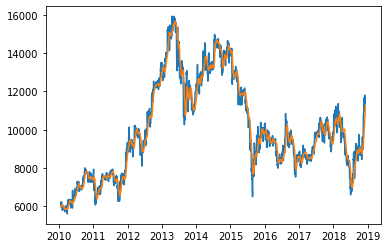

In [20]:
plt.plot(df['Adj Close'])
plt.plot(df['SMA'])

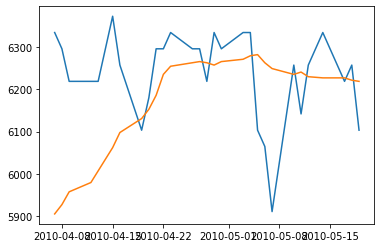

In [21]:
plt.plot(df['Adj Close'][50:80])
plt.plot(df['SMA'][50:80])

### Insight 1: Berdasarkan grafik diatas terlhat bahwa Price akan cenderung memantul terhadap SMA, jika price menembus SMA, maka arahnya akan terus melaju

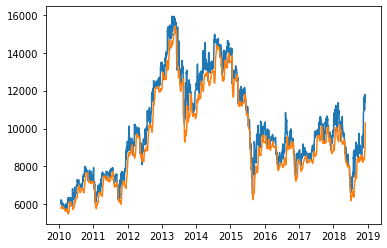

In [22]:
plt.plot(df['Adj Close'])
plt.plot(df['BBLower'])

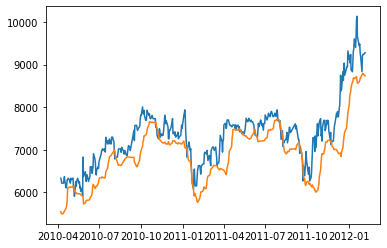

In [23]:
plt.plot(df['Adj Close'][50:500])
plt.plot(df['BBLower'][50:500])

### Insight 2: Price akan cenderung diatas Bollinger Band bawah, jika Price menyentuh Bollinger Band Bawah maka Price akan cenderung naik

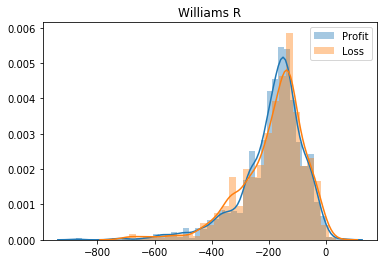

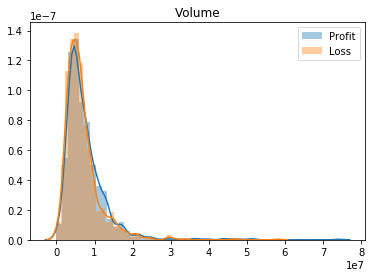

In [24]:
cp1 = []
cp0 = []
cp2 = []
cp3 = []
cp4 = []
cp5 = []
for i in range(len(df)):
    if df['Result'].iloc[i] == 'Profit' :
        cp1.append(df['Williams R'].iloc[i])
        cp4.append(df['Volume'].iloc[i])
    elif df['Result'].iloc[i] == 'Loss' :
        cp0.append(df['Williams R'].iloc[i])
        cp5.append(df['Volume'].iloc[i])

sns.distplot( cp1 , label="Profit").set_title('Williams R')
sns.distplot( cp0 , label="Loss")
plt.legend()
plt.show()
sns.distplot( cp4 , label="Profit").set_title('Volume')
sns.distplot( cp5 , label="Loss")
plt.legend()
plt.show()

### Insight 3:  ada kemungkinan jika volume besar akan terjadi profit pada periode waktu tertentu

In [25]:
df.head()

,High,Low,Adj Close,Volume,SMA,BBLower,Williams R,Result
Date,,,,,,,,
2010-01-22,8200.0,7800.0,6218.395020,6151000.0,5960.665248,5802.963108,-283.086426,Loss
2010-01-25,8100.0,7900.0,6103.238281,2309500.0,5988.083252,5795.273473,-349.460286,Loss
2010-01-26,8050.0,7900.0,6064.853027,3323000.0,6001.792201,5805.239880,-355.857829,Loss
2010-01-27,7950.0,7700.0,5988.083008,3832000.0,6007.275774,5808.104877,-368.652832,Profit
2010-01-28,8100.0,7800.0,6218.395020,3956000.0,6012.759347,5820.875622,-330.267497,Loss


In [26]:
df.reset_index(inplace=True)

In [27]:
data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
result = df['Result']

### XGBoost

In [28]:
from xgboost import XGBClassifier

In [29]:
xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)

In [31]:
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
print(classification_report(y_test, xgboost.predict(X_test)))

              precision    recall  f1-score   support

        Loss       0.71      0.61      0.66       218
      Profit       0.65      0.74      0.69       211

    accuracy                           0.68       429
   macro avg       0.68      0.68      0.67       429
weighted avg       0.68      0.68      0.67       429



In [33]:
data = classification_report(y_test, xgboost.predict(X_test))

In [34]:
pd.DataFrame(confusion_matrix(y_test,xgboost.predict(X_test)), columns = ['P Loss', 'P Profit'], index = ['A Loss', 'A Profit'])

,P Loss,P Profit
A Loss,133,85
A Profit,54,157


In [35]:
xgboost.predict_proba(X_test)

array([[0.13493776, 0.86506224],
       [0.16940492, 0.8305951 ],
       [0.54129   , 0.45871   ],
       [0.47541565, 0.52458435],
       [0.41374874, 0.58625126],
       [0.4658888 , 0.5341112 ],
       [0.53450114, 0.46549886],
       [0.83260864, 0.16739134],
       [0.25559384, 0.74440616],
       [0.6617212 , 0.33827874],
       [0.32769197, 0.672308  ],
       [0.38451236, 0.61548764],
       [0.56832355, 0.43167645],
       [0.7853613 , 0.2146387 ],
       [0.24929416, 0.75070584],
       [0.8550912 , 0.14490877],
       [0.20997506, 0.79002494],
       [0.61615014, 0.38384983],
       [0.38819873, 0.61180127],
       [0.7197039 , 0.2802961 ],
       [0.5077501 , 0.4922499 ],
       [0.70758796, 0.29241207],
       [0.38842416, 0.61157584],
       [0.6700388 , 0.32996118],
       [0.23718762, 0.7628124 ],
       [0.5986355 , 0.4013645 ],
       [0.80251676, 0.19748324],
       [0.5384657 , 0.46153432],
       [0.14447862, 0.8555214 ],
       [0.0594644 , 0.9405356 ],
       [0.

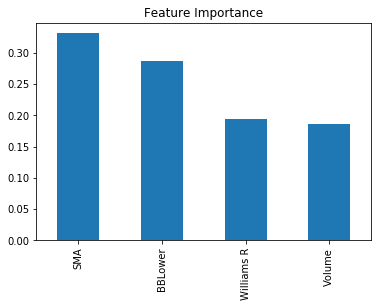

In [36]:
coef1 = pd.Series(xgboost.feature_importances_, X_train.columns).sort_values(ascending = False)
coef1.plot(kind = 'bar', title = 'Feature Importance')

In [37]:
accuracy_score(y_test,xgboost.predict(X_test))

0.675990675990676

In [38]:
from sklearn.model_selection import GridSearchCV

param_learning = (0.12, 0.1, 0.08, 0.06)
param_estimator = (80,100,120,140)
param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator}

gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7014577259475219
{'learning_rate': 0.1, 'n_estimators': 140}


In [39]:
xgboost = XGBClassifier(learning_rate = 0.08, n_estimators = 120, max_depth = 4)
xgboost.fit(X_train, y_train)
print(classification_report(y_test, xgboost.predict(X_test)))

              precision    recall  f1-score   support

        Loss       0.72      0.63      0.67       218
      Profit       0.66      0.75      0.71       211

    accuracy                           0.69       429
   macro avg       0.69      0.69      0.69       429
weighted avg       0.69      0.69      0.69       429



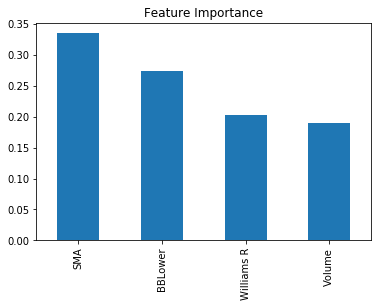

In [40]:
coef1 = pd.Series(xgboost.feature_importances_, X_train.columns).sort_values(ascending = False)
coef1.plot(kind = 'bar', title = 'Feature Importance')

### Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
predictions = logmodel.predict(X_test)

In [44]:
pd.DataFrame(confusion_matrix(y_test,predictions), columns = ['P No', 'P Yes'], index = ['A No', 'A Yes'])

,P No,P Yes
A No,82,136
A Yes,64,147


In [45]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

        Loss       0.56      0.38      0.45       218
      Profit       0.52      0.70      0.60       211

    accuracy                           0.53       429
   macro avg       0.54      0.54      0.52       429
weighted avg       0.54      0.53      0.52       429



### KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier

In [47]:
knn = KNeighborsClassifier(n_neighbors=2)

In [48]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [49]:
pred = knn.predict(X_test)

In [50]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

        Loss       0.50      0.72      0.59       218
      Profit       0.47      0.25      0.33       211

    accuracy                           0.49       429
   macro avg       0.48      0.49      0.46       429
weighted avg       0.48      0.49      0.46       429



### Jika melihat dari akurasi terlihat bahwa XGBoost mempunyai akurasi yang terbaik, sehingga saya akan menggunakan XGBoost untuk kedepannya

### "Hypertuning Variable"

In [52]:
def accuracyyy(stock):
    accuracies = []
    for n in range(1,31):
        df = Fetcher(stock,[2010,1,1],[2019,1,1]).getHistorical()
        df.drop(['Open','Close'], axis = 1, inplace = True)
        df['Date'] = pd.to_datetime(df['Date'])
        df.replace(0, np.nan, inplace=True)
        df.dropna(inplace = True)
        ma = []
        for i in range(len(df)):
            if i < 14:
                ma.append(np.nan)
            else:
                ma.append(df['Adj Close'][(i-14):i].mean())
        df['SMA'] = ma
        BBLower = []
        for i in range(len(df)):
            if i < 14 :
                BBLower.append(np.nan)
            else:
                BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
        df['BBLower'] = BBLower
        williamsr= []
        for i in range(len(df)):
            if i < 14 :
                williamsr.append(np.nan)
            else:
                high = df['High'].iloc[(i-14):(i)].max()
                low = df['Low'].iloc[(i-14):(i)].min()
                williamsr.append(((high-df['Adj Close'].iloc[i])/(high-low))*(-100))
        df['Williams R'] = williamsr
        result = []
        for i in range(len(df)):
            if i < n:
                result.append(np.nan)
            elif i > (len(df)-(n+1)):
                result.append(np.nan)
            else:
                if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+n]:
                    result.append('Profit')
                else:
                    result.append('Loss')
        df['Result'] = result
        df.dropna(axis = 0, inplace = True)
        data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
        result = df['Result']
        X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
        X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
        xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)
        xgboost.fit(X_train, y_train)
        param_learning = (0.12, 0.1, 0.08, 0.06)
        param_estimator = (80,100,120,140)
        max_depth = (1,2,3,4)
        param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator, 'max_depth':max_depth}
        gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')
        gs = gs.fit(X_train, y_train)
        learning_rates = 0
        n_estimatorss = 0
        max_depths = 0
        learning_rates += gs.best_params_['learning_rate']
        n_estimatorss += gs.best_params_['n_estimators']
        max_depths += gs.best_params_['max_depth']
        xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
        xgboost.fit(X_train, y_train)
        predictions = xgboost.predict(X_test)
        accuracies.append(accuracy_score(y_test,predictions))
    data = pd.DataFrame(accuracies)
    return data

In [53]:
angka = pd.DataFrame(accuracyyy('SMGR.JK'))
angka

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING,

,0
0,0.479167
1,0.546296
2,0.540603
3,0.568445
4,0.596288
5,0.663573
6,0.658933
7,0.644186
8,0.648837
9,0.667442


In [63]:
pd.DataFrame(angka[0].sort_values(ascending = False))

,0
27,0.759434
23,0.757647
24,0.741176
29,0.737589
17,0.735981
22,0.734742
28,0.732861
16,0.724299
19,0.721311
21,0.718310


In [64]:
bestresult = (angka[0].sort_values(ascending = False).reset_index()['index'][0] + 1)
bestresult

28

In [67]:

        df = Fetcher('SMGR.JK',[2010,1,1],[2019,1,1]).getHistorical()
        df.drop(['Open','Close'], axis = 1, inplace = True)
        df['Date'] = pd.to_datetime(df['Date'])
        df.replace(0, np.nan, inplace=True)
        df.dropna(inplace = True)
        ma = []
        for i in range(len(df)):
            if i < 14:
                ma.append(np.nan)
            else:
                ma.append(df['Adj Close'][(i-14):i].mean())
        df['SMA'] = ma
        BBLower = []
        for i in range(len(df)):
            if i < 14 :
                BBLower.append(np.nan)
            else:
                BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
        df['BBLower'] = BBLower
        williamsr= []
        for i in range(len(df)):
            if i < 14 :
                williamsr.append(np.nan)
            else:
                high = df['High'].iloc[(i-14):(i)].max()
                low = df['Low'].iloc[(i-14):(i)].min()
                williamsr.append(((high-df['Adj Close'].iloc[i])/(high-low))*(-100))
        df['Williams R'] = williamsr
        result = []
        for i in range(len(df)):
            if i < bestresult:
                result.append(np.nan)
            elif i > (len(df)-(bestresult+1)):
                result.append(np.nan)
            else:
                if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+bestresult]:
                    result.append('Profit')
                else:
                    result.append('Loss')
        df['Result'] = result
        df.dropna(axis = 0, inplace = True)
        data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
        result = df['Result']
        X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
        X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
        xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)
        xgboost.fit(X_train, y_train)
        param_learning = (0.12, 0.1, 0.08, 0.06)
        param_estimator = (80,100,120,140)
        max_depth = (1,2,3,4)
        param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator, 'max_depth':max_depth}
        gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')
        gs = gs.fit(X_train, y_train)
        learning_rates = 0
        n_estimatorss = 0
        max_depths = 0
        learning_rates += gs.best_params_['learning_rate']
        n_estimatorss += gs.best_params_['n_estimators']
        max_depths += gs.best_params_['max_depth']
        xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
        xgboost.fit(X_train, y_train)
        predictions = xgboost.predict(X_test)
        print(classification_report(y_test,predictions))
        

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

        Loss       0.73      0.68      0.71       190
      Profit       0.76      0.79      0.77       234

    accuracy                           0.75       424
   macro avg       0.74      0.74      0.74       424
weighted avg       0.74      0.75      0.74       424



### Otomatisasi 1 (Trial, Tanpa "Hypertuning Variable")

In [40]:
def decision(stock):
    df = Fetcher(stock,[2010,1,1],[2019,1,1]).getHistorical()
    df.drop(['Open','Close'], axis = 1, inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.replace(0, np.nan, inplace=True)
    df.dropna(inplace = True)
    ma = []
    for i in range(len(df)):
        if i < 14:
            ma.append(np.nan)
        else:
            ma.append(df['Adj Close'][(i-14):i].mean())
    df['SMA'] = ma
    BBLower = []
    for i in range(len(df)):
        if i < 14 :
            BBLower.append(np.nan)
        else:
            BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
    df['BBLower'] = BBLower
    williamsr= []
    for i in range(len(df)):
        if i < 14 :
            williamsr.append(np.nan)
        else:
            high = df['High'].iloc[(i-14):(i)].max()
            low = df['Low'].iloc[(i-14):(i)].min()
            williamsr.append(((high-df['Adj Close'].iloc[i])/(high-low))*(-100))
    df['Williams R'] = williamsr
    result = []
    for i in range(len(df)):
        if i < 14:
            result.append(np.nan)
        elif i > (len(df)-15):
            result.append(np.nan)
        else:
            if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+14]:
                result.append('Profit')
            else:
                result.append('Loss')
    df['Result'] = result
    df.dropna(axis = 0, inplace = True)
    data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
    result = df['Result']
    X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
    xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)
    xgboost.fit(X_train, y_train)
    param_learning = (0.12, 0.1, 0.08, 0.06)
    param_estimator = (80,100,120,140)
    max_depth = (1,2,3,4)
    param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator, 'max_depth':max_depth}
    gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')
    gs = gs.fit(X_train, y_train)
    learning_rates = 0
    n_estimatorss = 0
    max_depths = 0
    learning_rates += gs.best_params_['learning_rate']
    n_estimatorss += gs.best_params_['n_estimators']
    max_depths += gs.best_params_['max_depth']
    xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
    xgboost.fit(X_train, y_train)
    dfpredict = Fetcher(stock,[2019,10,28],[2019,11,15]).getHistorical()
    dfpredict = dfpredict[['Volume','Adj Close']]
    dfpredict['SMA'] = dfpredict['Adj Close'][13].mean()
    dfpredict['BBLower'] = df['SMA'].iloc[13] - (2 * df['Adj Close'][0:13].std())
    dfpredict['Williams R'] = ((high-df['Adj Close'].iloc[13])/(high-low))*(-100)
    dfpredict.drop('Adj Close', axis =1, inplace = True)
    decisions.append(xgboost.predict(pd.DataFrame(dfpredict.iloc[13]).transpose())[0])

In [41]:
def probability(stock):
    df = Fetcher(stock,[2010,1,1],[2019,1,1]).getHistorical()
    df.drop(['Open','Close'], axis = 1, inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.replace(0, np.nan, inplace=True)
    df.dropna(inplace = True)
    ma = []
    for i in range(len(df)):
        if i < 14:
            ma.append(np.nan)
        else:
            ma.append(df['Adj Close'][(i-14):i].mean())
    df['SMA'] = ma
    BBLower = []
    for i in range(len(df)):
        if i < 14 :
            BBLower.append(np.nan)
        else:
            BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
    df['BBLower'] = BBLower
    williamsr= []
    for i in range(len(df)):
        if i < 14 :
            williamsr.append(np.nan)
        else:
            high = df['High'].iloc[(i-14):(i)].max()
            low = df['Low'].iloc[(i-14):(i)].min()
            williamsr.append(((high-df['Adj Close'].iloc[i])/(high-low))*(-100))
    df['Williams R'] = williamsr
    result = []
    for i in range(len(df)):
        if i < 14:
            result.append(np.nan)
        elif i > (len(df)-15):
            result.append(np.nan)
        else:
            if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+14]:
                result.append('Profit')
            else:
                result.append('Loss')
    df['Result'] = result
    df.dropna(axis = 0, inplace = True)
    data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
    result = df['Result']
    X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
    xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)
    xgboost.fit(X_train, y_train)
    param_learning = (0.12, 0.1, 0.08, 0.06)
    param_estimator = (80,100,120,140)
    max_depth = (1,2,3,4)
    param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator, 'max_depth':max_depth}
    gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')
    gs = gs.fit(X_train, y_train)
    learning_rates = 0q
    n_estimatorss = 0
    max_depths = 0
    learning_rates += gs.best_params_['learning_rate']
    n_estimatorss += gs.best_params_['n_estimators']
    max_depths += gs.best_params_['max_depth']
    xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
    xgboost.fit(X_train, y_train)
    dfpredict = Fetcher(stock,[2019,10,28],[2019,11,15]).getHistorical()
    dfpredict = dfpredict[['Volume','Adj Close']]
    dfpredict['SMA'] = dfpredict['Adj Close'][13].mean()
    dfpredict['BBLower'] = df['SMA'].iloc[13] - (2 * df['Adj Close'][0:13].std())
    dfpredict['Williams R'] = ((high-df['Adj Close'].iloc[13])/(high-low))*(-100)
    dfpredict.drop('Adj Close', axis =1, inplace = True)
    if xgboost.predict(pd.DataFrame(dfpredict.iloc[13]).transpose())[0] == 'Loss':
         return pd.DataFrame(xgboost.predict_proba(pd.DataFrame(dfpredict.iloc[13]).transpose()))[0][0]
    elif xgboost.predict(pd.DataFrame(dfpredict.iloc[13]).transpose())[0] == 'Profit':
         return pd.DataFrame(xgboost.predict_proba(pd.DataFrame(dfpredict.iloc[13]).transpose()))[1][0]

In [42]:
def accuracyy(stock):
    df = Fetcher(stock,[2010,1,1],[2019,1,1]).getHistorical()
    df.drop(['Open','Close'], axis = 1, inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.replace(0, np.nan, inplace=True)
    df.dropna(inplace = True)
    ma = []
    for i in range(len(df)):
        if i < 14:
            ma.append(np.nan)
        else:
            ma.append(df['Adj Close'][(i-14):i].mean())
    df['SMA'] = ma
    BBLower = []
    for i in range(len(df)):
        if i < 14 :
            BBLower.append(np.nan)
        else:
            BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
    df['BBLower'] = BBLower
    williamsr= []
    for i in range(len(df)):
        if i < 14 :
            williamsr.append(np.nan)
        else:
            high = df['High'].iloc[(i-14):(i)].max()
            low = df['Low'].iloc[(i-14):(i)].min()
            williamsr.append(((high-df['Adj Close'].iloc[i])/(high-low))*(-100))
    df['Williams R'] = williamsr
    result = []
    for i in range(len(df)):
        if i < 14:
            result.append(np.nan)
        elif i > (len(df)-15):
            result.append(np.nan)
        else:
            if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+14]:
                result.append('Profit')
            else:
                result.append('Loss')
    df['Result'] = result
    df.dropna(axis = 0, inplace = True)
    data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
    result = df['Result']
    X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
    X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
    xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)
    xgboost.fit(X_train, y_train)
    param_learning = (0.12, 0.1, 0.08, 0.06)
    param_estimator = (80,100,120,140)
    max_depth = (1,2,3,4)
    param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator, 'max_depth':max_depth}
    gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')
    gs = gs.fit(X_train, y_train)
    learning_rates = 0
    n_estimatorss = 0
    max_depths = 0
    learning_rates += gs.best_params_['learning_rate']
    n_estimatorss += gs.best_params_['n_estimators']
    max_depths += gs.best_params_['max_depth']
    xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
    xgboost.fit(X_train, y_train)
    predictions = xgboost.predict(X_test)
    return accuracy_score(y_test,predictions)

In [167]:
decisions = []
percentage = []
accuracy = []
lq45 = ['ADHI.JK','ADRO.JK','ASII.JK','ASRI.JK','BBCA.JK','BBNI.JK','BBRI.JK','BBTN.JK','BKSL.JK','BMRI.JK',
       'CPIN.JK','INTP.JK','ITMG.JK','JSMR.JK','KLBF.JK','LPKR.JK','LPPF.JK','MNCN.JK','PTBA.JK','PTPP.JK','SCMA.JK','SMGR.JK',
       'SSMS.JK','TPIA.JK','UNTR.JK','UNVR.JK','WIKA.JK','WSKT.JK','ELSA.JK','EXCL.JK','GGRM.JK','HMSP.JK','ICBP.JK','INCO.JK','INDF.JK','INDY.JK']
for i in range(len(lq45)):
    decision(lq45[i])
    percentage.append(probability(lq45[i]))
    accuracy.append(accuracyy(lq45[i]))
hasil = pd.DataFrame(lq45, columns = ['Saham'])
hasil['Prediction Result'] = decisions
hasil['Probability'] = percentage
hasil['Accuracy'] = accuracy
hasil

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING,

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING,

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING,

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING,

,Saham,Prediction Result,Probability,Accuracy
0,ADHI.JK,Profit,0.791072,0.710956
1,ADRO.JK,Profit,0.778645,0.666667
2,ASII.JK,Loss,0.589525,0.717949
3,ASRI.JK,Loss,0.567787,0.706294
4,BBCA.JK,Profit,0.579629,0.687646
5,BBNI.JK,Loss,0.782129,0.657343
6,BBRI.JK,Loss,0.773302,0.750583
7,BBTN.JK,Profit,0.934113,0.713287
8,BKSL.JK,Loss,0.550871,0.755245
9,BMRI.JK,Loss,0.783795,0.699301


In [138]:
lq45 = ['ADHI.JK','ADRO.JK','ASII.JK','ASRI.JK','BBCA.JK','BBNI.JK','BBRI.JK','BBTN.JK','BKSL.JK','BMRI.JK',
       'BSDE.JK','CPIN.JK','ELSA.JK','EXCL.JK','GGRM.JK','HMSP.JK','ICBP.JK','INCO.JK','INDF.JK','INDY.JK','INKP.JK','INTP.JK',
       'ITMG.JK','JSMR.JK','KLBF.JK','LPKR.JK','LPPF.JK','MEDC.JK','MNCN.JK','PGAS.JK','PTBA.JK','PTPP.JK','SCMA.JK','SMGR.JK',
       'SRIL.JK','SSMS.JK','TLKM.JK','TPIA.JK','UNTR.JK','UNVR.JK','WIKA.JK','WSBP.JK','WSKT.JK']

### Otomatisasi 2 (Lebih Cepat, Tanpa "Hypertuning Variable")

In [186]:
def model(stock):
    df = Fetcher(stock,[2010,1,1],[2019,1,1]).getHistorical()
    df.drop(['Open','Close'], axis = 1, inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.replace(0, np.nan, inplace=True)
    df.dropna(inplace = True)
    ma = []
    for i in range(len(df)):
        if i < 14:
            ma.append(np.nan)
        else:
            ma.append(df['Adj Close'][(i-14):i].mean())
    df['SMA'] = ma
    BBLower = []
    for i in range(len(df)):
        if i < 14 :
            BBLower.append(np.nan)
        else:
            BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
    df['BBLower'] = BBLower
    williamsr= []
    for i in range(len(df)):
        if i < 14 :
            williamsr.append(np.nan)
        else:
            high = df['High'].iloc[(i-14):(i)].max()
            low = df['Low'].iloc[(i-14):(i)].min()
            williamsr.append(((high-df['Adj Close'].iloc[i])/(high-low))*(-100))
    df['Williams R'] = williamsr
    result = []
    for i in range(len(df)):
        if i < 14:
            result.append(np.nan)
        elif i > (len(df)-15):
            result.append(np.nan)
        else:
            if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+14]:
                result.append('Profit')
            else:
                result.append('Loss')
    df['Result'] = result
    df.dropna(axis = 0, inplace = True)
    data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
    result = df['Result']
    X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
    X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
    xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)
    xgboost.fit(X_train, y_train)
    param_learning = (0.12, 0.1, 0.08, 0.06)
    param_estimator = (80,100,120,140)
    max_depth = (1,2,3,4)
    param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator, 'max_depth':max_depth}
    gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')
    gs = gs.fit(X_train, y_train)
    learning_rates = 0
    n_estimatorss = 0
    max_depths = 0
    learning_rates += gs.best_params_['learning_rate']
    n_estimatorss += gs.best_params_['n_estimators']
    max_depths += gs.best_params_['max_depth']
    xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
    xgboost.fit(X_train, y_train)
    predictions = xgboost.predict(X_test)
    dfpredict = Fetcher(stock,[2019,10,28],[2019,11,15]).getHistorical()
    dfpredict = dfpredict[['Volume','Adj Close']]
    dfpredict['SMA'] = dfpredict['Adj Close'][13].mean()
    dfpredict['BBLower'] = df['SMA'].iloc[13] - (2 * df['Adj Close'][0:13].std())
    dfpredict['Williams R'] = ((high-df['Adj Close'].iloc[13])/(high-low))*(-100)
    dfpredict.drop('Adj Close', axis =1, inplace = True)
    for i in range(1,31):
        
    df2 = []
    if xgboost.predict(pd.DataFrame(dfpredict.iloc[13]).transpose())[0] == 'Loss':
          df2.append([stock,
                xgboost.predict(pd.DataFrame(dfpredict.iloc[13]).transpose())[0],
                pd.DataFrame(xgboost.predict_proba(pd.DataFrame(dfpredict.iloc[13]).transpose()))[0][0],
                accuracy_score(y_test,predictions)])
    elif xgboost.predict(pd.DataFrame(dfpredict.iloc[13]).transpose())[0] == 'Profit':
          df2.append([stock,
                xgboost.predict(pd.DataFrame(dfpredict.iloc[13]).transpose())[0],
                pd.DataFrame(xgboost.predict_proba(pd.DataFrame(dfpredict.iloc[13]).transpose()))[1][0],
                accuracy_score(y_test,predictions)])
    return df2

In [197]:
df3 = []

lq45 = ['ADHI.JK','ADRO.JK','ASII.JK','ASRI.JK','BBCA.JK','BBNI.JK','BBRI.JK','BBTN.JK','BKSL.JK','BMRI.JK',
       'CPIN.JK','INTP.JK','ITMG.JK','JSMR.JK','KLBF.JK','LPKR.JK','LPPF.JK','MNCN.JK','PTBA.JK','PTPP.JK','SCMA.JK','SMGR.JK',
       'SSMS.JK','TPIA.JK','UNTR.JK','UNVR.JK','WIKA.JK','WSKT.JK','ELSA.JK','EXCL.JK','GGRM.JK','HMSP.JK','ICBP.JK','INCO.JK','INDF.JK','INDY.JK']
for i in range(len(lq45)):
    df3.append(model(lq45[i])[0])
pd.DataFrame(df3, columns = ['Stocks', 'Prediction', 'Probability', 'Accuracy'])


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING,

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING,

,Stocks,Prediction,Probability,Accuracy
0,ADHI.JK,Profit,0.553481,0.731935
1,ADRO.JK,Profit,0.711509,0.689977
2,ASII.JK,Profit,0.575317,0.736597
3,ASRI.JK,Profit,0.776720,0.680653
4,BBCA.JK,Profit,0.834400,0.717949
5,BBNI.JK,Loss,0.613778,0.666667
6,BBRI.JK,Profit,0.873405,0.748252
7,BBTN.JK,Profit,0.855418,0.692308
8,BKSL.JK,Loss,0.579466,0.680653
9,BMRI.JK,Profit,0.613004,0.734266


### Otomatisasi 3 ("Hypertuning Variable")

In [68]:
def bestresults(stock):
    accuracies = []
    for n in range(1,31):
        df = Fetcher(stock,[2010,1,1],[2019,1,1]).getHistorical()
        df.drop(['Open','Close'], axis = 1, inplace = True)
        df['Date'] = pd.to_datetime(df['Date'])
        df.replace(0, np.nan, inplace=True)
        df.dropna(inplace = True)
        ma = []
        for i in range(len(df)):
            if i < 14:
                ma.append(np.nan)
            else:
                ma.append(df['Adj Close'][(i-14):i].mean())
        df['SMA'] = ma
        BBLower = []
        for i in range(len(df)):
            if i < 14 :
                BBLower.append(np.nan)
            else:
                BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
        df['BBLower'] = BBLower
        williamsr= []
        for i in range(len(df)):
            if i < 14 :
                williamsr.append(np.nan)
            else:
                high = df['High'].iloc[(i-14):(i)].max()
                low = df['Low'].iloc[(i-14):(i)].min()
                williamsr.append(((high-df['Adj Close'].iloc[i])/(high-low))*(-100))
        df['Williams R'] = williamsr
        result = []
        for i in range(len(df)):
            if i < n:
                result.append(np.nan)
            elif i > (len(df)-(n+1)):
                result.append(np.nan)
            else:
                if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+n]:
                    result.append('Profit')
                else:
                    result.append('Loss')
        df['Result'] = result
        df.dropna(axis = 0, inplace = True)
        data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
        result = df['Result']
        X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
        X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
        xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)
        xgboost.fit(X_train, y_train)
        param_learning = (0.12, 0.1, 0.08, 0.06)
        param_estimator = (80,100,120,140)
        max_depth = (1,2,3,4)
        param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator, 'max_depth':max_depth}
        gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')
        gs = gs.fit(X_train, y_train)
        learning_rates = 0
        n_estimatorss = 0
        max_depths = 0
        learning_rates += gs.best_params_['learning_rate']
        n_estimatorss += gs.best_params_['n_estimators']
        max_depths += gs.best_params_['max_depth']
        xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
        xgboost.fit(X_train, y_train)
        predictions = xgboost.predict(X_test)
        accuracies.append(accuracy_score(y_test,predictions))
    angka = pd.DataFrame(accuracies)
    bestresult = (angka[0].sort_values(ascending = False).reset_index()['index'][0] + 1)
    return bestresult

In [ ]:
bestresults()

In [82]:
def modelnextlevel(stock):
    df = Fetcher(stock,[2010,1,1],[2019,1,1]).getHistorical()
    df.drop(['Open','Close'], axis = 1, inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.replace(0, np.nan, inplace=True)
    df.dropna(inplace = True)
    ma = []
    for i in range(len(df)):
        if i < 14:
            ma.append(np.nan)
        else:
            ma.append(df['Adj Close'][(i-14):i].mean())
    df['SMA'] = ma
    BBLower = []
    for i in range(len(df)):
        if i < 14 :
            BBLower.append(np.nan)
        else:
            BBLower.append((df['SMA'].iloc[i] - (2 * df['Adj Close'][(i-14):i].std())))
    df['BBLower'] = BBLower
    williamsr= []
    for i in range(len(df)):
        if i < 14 :
            williamsr.append(np.nan)
        else:
            high = df['High'].iloc[(i-14):(i)].max()
            low = df['Low'].iloc[(i-14):(i)].min()
            williamsr.append(((high-df['Adj Close'].iloc[i])/(high-low))*(-100))
    df['Williams R'] = williamsr
    result = []
    for i in range(len(df)):
        if i < 14:
            result.append(np.nan)
        elif i > (len(df)-15):
            result.append(np.nan)
        else:
            if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+14]:
                result.append('Profit')
            else:
                result.append('Loss')
    df['Result'] = result
    df.dropna(axis = 0, inplace = True)
    data = df.drop(['Date','Result','Adj Close', 'High','Low'],axis = 1)
    result = df['Result']
    X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
    X_train, X_test, y_train, y_test = train_test_split(data, result, test_size = 0.2)
    xgboost = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4)
    xgboost.fit(X_train, y_train)
    param_learning = (0.12, 0.1, 0.08, 0.06)
    param_estimator = (80,100,120,140)
    max_depth = (1,2,3,4)
    param_grid = {'learning_rate': param_learning, 'n_estimators':param_estimator, 'max_depth':max_depth}
    gs = GridSearchCV(xgboost,param_grid,scoring='accuracy')
    gs = gs.fit(X_train, y_train)
    learning_rates = 0
    n_estimatorss = 0
    max_depths = 0
    learning_rates += gs.best_params_['learning_rate']
    n_estimatorss += gs.best_params_['n_estimators']
    max_depths += gs.best_params_['max_depth']
    xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
    xgboost.fit(X_train, y_train)
    angka = 0
    angka += bestresults(stock)
    accuracies = []  
    predictions = xgboost.predict(X_test)
    resultnew = []
    for i in range(len(df)):
        if i <  angka:
            resultnew.append(np.nan)
        elif i > (len(df)-(angka + 1)):
            resultnew.append(np.nan)
        else:
            if df['Adj Close'].iloc[i] < df['Adj Close'].iloc[i+angka]:
                resultnew.append('Profit')
            else:
                resultnew.append('Loss')
    df['Result'] = resultnew
    xgboost = XGBClassifier(learning_rate = learning_rates, n_estimators = n_estimatorss, max_depth = max_depths)
    xgboost.fit(X_train, y_train)
    dfpredict = Fetcher(stock,[2019,10,8],[2019,11,18]).getHistorical()
    dfpredict = dfpredict[['Volume','Adj Close']]
    dfpredict['SMA'] = dfpredict['Adj Close'][-angka:-1].mean()
    dfpredict['BBLower'] = df['SMA'].iloc[-1] - (2 * df['Adj Close'][-angka:].std())
    dfpredict['Williams R'] = ((high-df['Adj Close'].iloc[-angka])/(high-low))*(-100)
    dfpredict.drop('Adj Close', axis =1, inplace = True)
    df2 = []
    if xgboost.predict(pd.DataFrame(dfpredict.iloc[-1]).transpose())[0] == 'Loss':
          df2.append([stock,
                xgboost.predict(pd.DataFrame(dfpredict.iloc[-1]).transpose())[0],
                pd.DataFrame(xgboost.predict_proba(pd.DataFrame(dfpredict.iloc[-1]).transpose()))[0][0],
                accuracy_score(y_test,predictions),angka])
    elif xgboost.predict(pd.DataFrame(dfpredict.iloc[-1]).transpose())[0] == 'Profit':
          df2.append([stock,
                xgboost.predict(pd.DataFrame(dfpredict.iloc[-1]).transpose())[0],
                pd.DataFrame(xgboost.predict_proba(pd.DataFrame(dfpredict.iloc[-1]).transpose()))[1][0],
                accuracy_score(y_test,predictions),angka])
    return df2

In [83]:
df3 = []

lq45 = ['ADHI.JK','ADRO.JK']
for i in range(len(lq45)):
    df3.append(modelnextlevel(lq45[i])[0])
pd.DataFrame(df3, columns = ['Stocks', 'Prediction', 'Probability', 'Accuracy', 'Best Time'])


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING,

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING,

,Stocks,Prediction,Probability,Accuracy,Best Time
0,ADHI.JK,Profit,0.572951,0.717949,24
1,ADRO.JK,Profit,0.663573,0.717949,30
